## Pasta Wars

Welcome to the Pasta Wars! We're going to use convolutional neural networks (CNNs) to allow our computer to see - something that is only possible thanks to deep learning in classifying between different types of Pastas.

## Introduction to Pasta Wars: 'Penne Vs Spaghetti'

We're going to try to create a model to classify the Penne Vs Spaghetti.

In [1]:
# Put these at the top of every notebook, to get automatic reloading and inline plotting
%reload_ext autoreload
%autoreload 2
%matplotlib inline

Here we import the libraries we need. We'll learn about what each does during the course.

In [2]:
# This file contains all the main external libs we'll use
from fastai.imports import *

In [3]:
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *

In [4]:
PATH = "/home/paperspace/projects/pastas/data/pastas/"
sz=224

In [5]:
torch.cuda.is_available()

True

In [6]:
torch.backends.cudnn.enabled

True

## First look at Pasta pictures

Our library will assume that you have *train* and *valid* directories. It also assumes that each dir will have subdirs for each class you wish to recognize (in this case, 'Penne' and 'Spaghetti').

In [7]:
os.listdir(PATH)
#PATH

['valid', 'train']

In [8]:
os.listdir(f'{PATH}valid')

['spaghetti', 'penne']

In [9]:
files = os.listdir(f'{PATH}valid/penne')[:5]
files

['00000587.jpg',
 '00000565.jpg',
 '00000595.jpg',
 '00000597.jpg',
 '00000569.jpg']

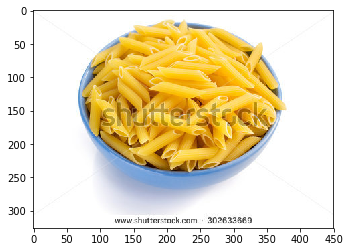

In [10]:
img = plt.imread(f'{PATH}valid/penne/{files[0]}')
plt.imshow(img);

In [11]:
files = os.listdir(f'{PATH}valid/spaghetti')[:5]
files

['00000664.jpg',
 '00000678.jpg',
 '00000687.jpg',
 '00000698.jpg',
 '00000662.jpg']

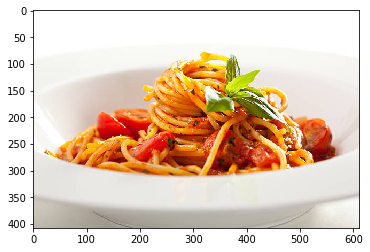

In [12]:
img = plt.imread(f'{PATH}valid/spaghetti/{files[0]}')
plt.imshow(img);

Here is how the raw data looks like

In [13]:
img.shape

(408, 612, 3)

In [14]:
img[:4,:4]

array([[[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]]], dtype=uint8)

## Our first model: quick start

We're going to use a <b>pre-trained</b> model, that is, a model created by some one else to solve a different problem. Instead of building a model from scratch to solve a similar problem, we'll use a model trained on ImageNet (1.2 million images and 1000 classes) as a starting point. The model is a Convolutional Neural Network (CNN), a type of Neural Network that builds state-of-the-art models for computer vision. 

We will be using the <b>resnet34</b> model. resnet34 is a version of the model that won the 2015 ImageNet competition. Here is more info on [resnet models](https://github.com/KaimingHe/deep-residual-networks). 

Here's how to train and evalulate a *Penne vs Spaghetti* model in 3 lines of code, and under 20 seconds:

In [15]:
arch=resnet34
data = ImageClassifierData.from_paths(PATH, tfms=tfms_from_model(arch, sz))
learn = ConvLearner.pretrained(arch, data, precompute=True)
learn.fit(0.01, 2)

100%|██████████| 1/1 [00:01<00:00,  1.20s/it]


HBox(children=(IntProgress(value=0, description='Epoch', max=2), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                 
    0      0.496161   0.256919   0.883333  
    1      0.331849   0.16391    0.95                     



[0.16391048, 0.949999988079071]

How good is this model? Well, our initial model has 94.9% accuracy, which is an amazing start with very few samples.

## Analyzing results: looking at pictures

As well as looking at the overall metrics, it's also a good idea to look at examples of each of:
1. A few correct labels at random
2. A few incorrect labels at random
3. The most correct labels of each class (ie those with highest probability that are correct)
4. The most incorrect labels of each class (ie those with highest probability that are incorrect)
5. The most uncertain labels (ie those with probability closest to 0.5).

In [16]:
# This is the label for a val data
data.val_y

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [17]:
# from here we know that 'cats' is label 0 and 'dogs' is label 1.
data.classes

['penne', 'spaghetti']

In [18]:
# this gives prediction for validation set. Predictions are in log scale
log_preds = learn.predict()
log_preds.shape

(60, 2)

In [19]:
log_preds[:10]

array([[ -0.18982,  -1.75508],
       [ -0.37255,  -1.16788],
       [ -0.00625,  -5.07811],
       [ -0.14028,  -2.0334 ],
       [ -0.0094 ,  -4.6715 ],
       [ -0.10268,  -2.32707],
       [ -0.00004, -10.21546],
       [ -0.00536,  -5.23055],
       [ -0.00537,  -5.22941],
       [ -0.22736,  -1.59274]], dtype=float32)

In [20]:
preds = np.argmax(log_preds, axis=1)  # from log probabilities to 0 or 1
probs = np.exp(log_preds[:,1])        # pr(dog)

In [21]:
def rand_by_mask(mask): return np.random.choice(np.where(mask)[0], 4, replace=False)
def rand_by_correct(is_correct): return rand_by_mask((preds == data.val_y)==is_correct)

In [22]:
def plot_val_with_title(idxs, title):
    imgs = np.stack([data.val_ds[x][0] for x in idxs])
    title_probs = [probs[x] for x in idxs]
    print(title)
    return plots(data.val_ds.denorm(imgs), rows=1, titles=title_probs)

In [23]:
def plots(ims, figsize=(12,6), rows=1, titles=None):
    f = plt.figure(figsize=figsize)
    for i in range(len(ims)):
        sp = f.add_subplot(rows, len(ims)//rows, i+1)
        sp.axis('Off')
        if titles is not None: sp.set_title(titles[i], fontsize=16)
        plt.imshow(ims[i])

In [24]:
def load_img_id(ds, idx): return np.array(PIL.Image.open(PATH+ds.fnames[idx]))

def plot_val_with_title(idxs, title):
    imgs = [load_img_id(data.val_ds,x) for x in idxs]
    title_probs = [probs[x] for x in idxs]
    print(title)
    return plots(imgs, rows=1, titles=title_probs, figsize=(16,8))

Correctly classified


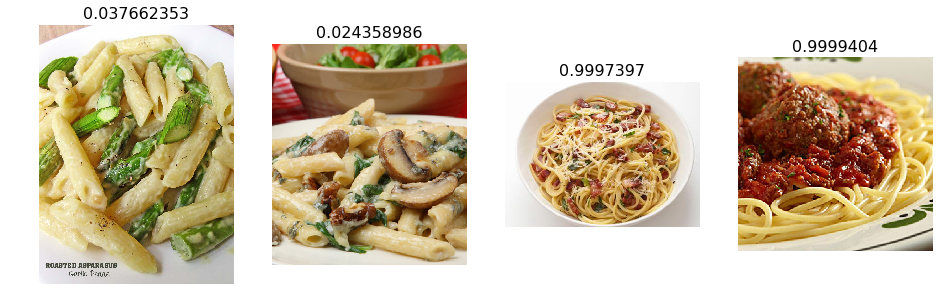

In [25]:
# 1. A few correct labels at random
plot_val_with_title(rand_by_correct(True), "Correctly classified")

In [27]:
def most_by_mask(mask, mult):
    idxs = np.where(mask)[0]
    return idxs[np.argsort(mult * probs[idxs])[:4]]

def most_by_correct(y, is_correct): 
    mult = -1 if (y==1)==is_correct else 1
    return most_by_mask(((preds == data.val_y)==is_correct) & (data.val_y == y), mult)

Most correct Penne Pastas


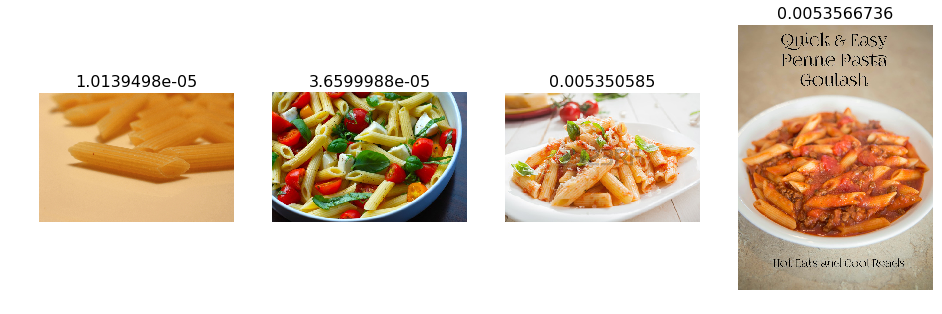

In [29]:
plot_val_with_title(most_by_correct(0, True), "Most correct Penne Pastas")

Most correct Spaghetti Pastas


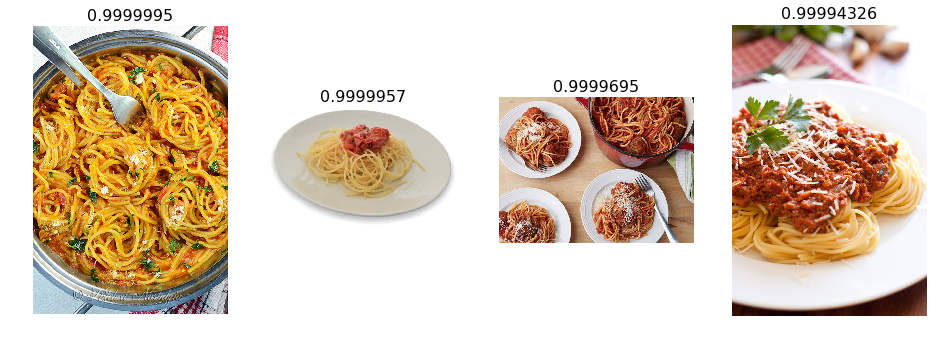

In [30]:
plot_val_with_title(most_by_correct(1, True), "Most correct Spaghetti Pastas")

Most incorrect Spaghetti Pastas


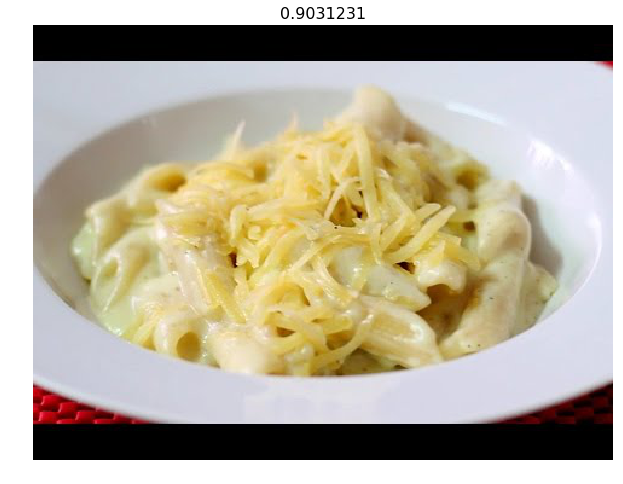

In [31]:
plot_val_with_title(most_by_correct(0, False), "Most incorrect Spaghetti Pastas")

Most incorrect Penne Pastas


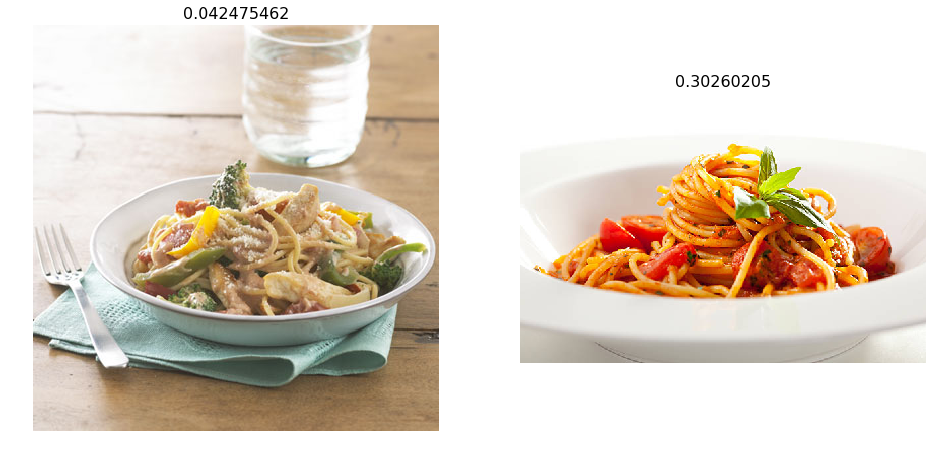

In [32]:
plot_val_with_title(most_by_correct(1, False), "Most incorrect Penne Pastas")

Most uncertain predictions


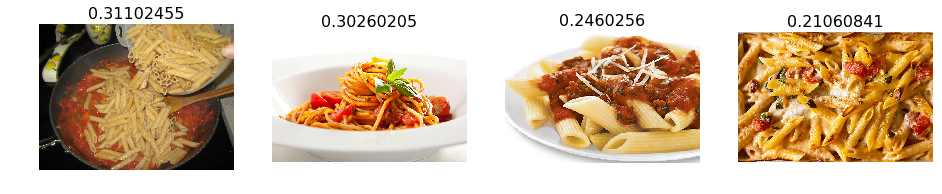

In [33]:
most_uncertain = np.argsort(np.abs(probs -0.5))[:4]
plot_val_with_title(most_uncertain, "Most uncertain predictions")

## Choosing a learning rate

The *learning rate* determines how quickly or how slowly you want to update the *weights* (or *parameters*). Learning rate is one of the most difficult parameters to set, because it significantly affect model performance.

The method `learn.lr_find()` helps you find an optimal learning rate. It uses the technique developed in the 2015 paper [Cyclical Learning Rates for Training Neural Networks](http://arxiv.org/abs/1506.01186), where we simply keep increasing the learning rate from a very small value, until the loss stops decreasing. We can plot the learning rate across batches to see what this looks like.

We first create a new learner, since we want to know how to set the learning rate for a new (untrained) model.

In [34]:
learn = ConvLearner.pretrained(arch, data, precompute=True)

In [35]:
lrf=learn.lr_find()

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                 
    0      1.053643   121.604393 0.866667  



Our `learn` object contains an attribute `sched` that contains our learning rate scheduler, and has some convenient plotting functionality including this one:

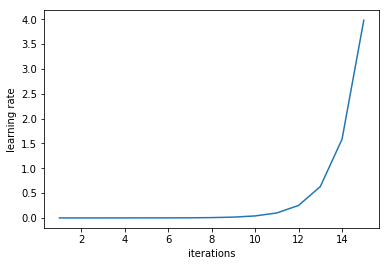

In [36]:
learn.sched.plot_lr()

Note that in the previous plot *iteration* is one iteration (or *minibatch*) of SGD. In one epoch there are 
(num_train_samples/num_iterations) of SGD.

We can see the plot of loss versus learning rate to see where our loss stops decreasing:

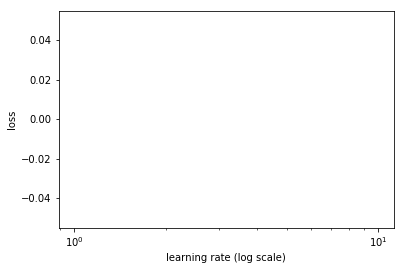

In [37]:
learn.sched.plot()

The loss is still clearly improving at lr=1e-2 (0.01), so that's what we use. Note that the optimal learning rate can change as we training the model, so you may want to re-run this function from time to time.

## Improving our model

### Data augmentation

If you try training for more epochs, you'll notice that we start to *overfit*, which means that our model is learning to recognize the specific images in the training set, rather than generalizing such that we also get good results on the validation set. One way to fix this is to effectively create more data, through *data augmentation*. This refers to randomly changing the images in ways that shouldn't impact their interpretation, such as horizontal flipping, zooming, and rotating.

We can do this by passing `aug_tfms` (*augmentation transforms*) to `tfms_from_model`, with a list of functions to apply that randomly change the image however we wish. For photos that are largely taken from the side (e.g. most photos of penne and spaghetti, as opposed to photos taken from the top down, such as satellite imagery) we can use the pre-defined list of functions `transforms_side_on`. We can also specify random zooming of images up to specified scale by adding the `max_zoom` parameter.

In [38]:
tfms = tfms_from_model(resnet34, sz, aug_tfms=transforms_side_on, max_zoom=1.1)

In [39]:
def get_augs():
    data = ImageClassifierData.from_paths(PATH, bs=2, tfms=tfms, num_workers=1)
    x,_ = next(iter(data.aug_dl))
    return data.trn_ds.denorm(x)[1]

In [40]:
ims = np.stack([get_augs() for i in range(6)])

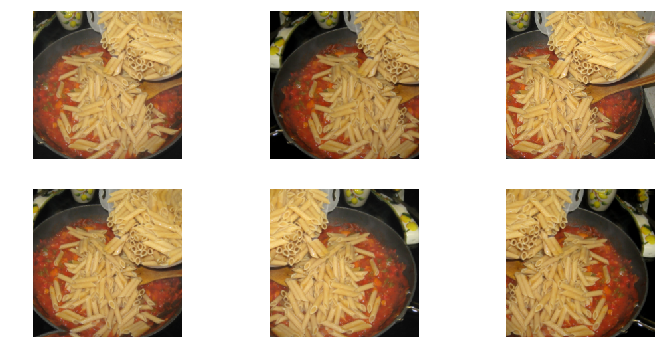

In [41]:
plots(ims, rows=2)

Let's create a new `data` object that includes this augmentation in the transforms.

In [42]:
data = ImageClassifierData.from_paths(PATH, tfms=tfms)
learn = ConvLearner.pretrained(arch, data, precompute=True)

In [43]:
learn.fit(1e-2, 1)

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                 
    0      0.512179   0.306452   0.85      



[0.30645168, 0.8500000238418579]

In [44]:
learn.precompute=False

By default when we create a learner, it sets all but the last layer to *frozen*. That means that it's still only updating the weights in the last layer when we call `fit`.

In [45]:
learn.fit(1e-2, 3, cycle_len=1)

HBox(children=(IntProgress(value=0, description='Epoch', max=3), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                  
    0      0.227141   0.22962    0.9       
    1      0.237166   0.186229   0.916667                  
    2      0.222767   0.162098   0.933333                  



[0.16209841, 0.9333333373069763]

What is that `cycle_len` parameter? What we've done here is used a technique called *stochastic gradient descent with restarts (SGDR)*, a variant of *learning rate annealing*, which gradually decreases the learning rate as training progresses. This is helpful because as we get closer to the optimal weights, we want to take smaller steps.

However, we may find ourselves in a part of the weight space that isn't very resilient - that is, small changes to the weights may result in big changes to the loss. We want to encourage our model to find parts of the weight space that are both accurate and stable. Therefore, from time to time we increase the learning rate (this is the 'restarts' in 'SGDR'), which will force the model to jump to a different part of the weight space if the current area is "spikey". Here's a picture of how that might look if we reset the learning rates 3 times (in this paper they call it a "cyclic LR schedule"):

<img src="images/sgdr.png" width="80%">
(From the paper [Snapshot Ensembles](https://arxiv.org/abs/1704.00109)).

The number of epochs between resetting the learning rate is set by `cycle_len`, and the number of times this happens is refered to as the *number of cycles*, and is what we're actually passing as the 2nd parameter to `fit()`. So here's what our actual learning rates looked like:

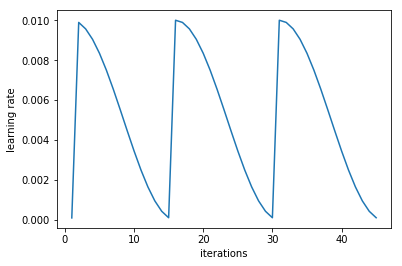

In [46]:
learn.sched.plot_lr()

Our validation loss isn't improving much, so there's probably no point further training the last layer on its own.

Since we've got a pretty good model at this point, we might want to save it so we can load it again later without training it from scratch.

In [47]:
learn.save('Pastas_lastlayer')

In [48]:
learn.load('Pastas_lastlayer')

### Fine-tuning and differential learning rate annealing

Now that we have a good final layer trained, we can try fine-tuning the other layers. To tell the learner that we want to unfreeze the remaining layers, just call (surprise surprise!) `unfreeze()`.

In [49]:
learn.unfreeze()

Note that the other layers have *already* been trained to recognize imagenet photos (whereas our final layers where randomly initialized), so we want to be careful of not destroying the carefully tuned weights that are already there.

Generally speaking, the earlier layers (as we've seen) have more general-purpose features. Therefore we would expect them to need less fine-tuning for new datasets. For this reason we will use different learning rates for different layers: the first few layers will be at 1e-4, the middle layers at 1e-3, and our FC layers we'll leave at 1e-2 as before. We refer to this as *differential learning rates*, although there's no standard name for this techique in the literature that we're aware of.

In [50]:
lr=np.array([1e-4,1e-3,1e-2])

In [51]:
learn.fit(lr, 3, cycle_len=1, cycle_mult=2)

HBox(children=(IntProgress(value=0, description='Epoch', max=7), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                  
    0      0.334906   0.170766   0.933333  
    1      0.272877   0.153154   0.933333                  
    2      0.214328   0.135154   0.933333                  
    3      0.174709   0.07128    0.983333                  
    4      0.154046   0.056467   0.983333                  
    5      0.13154    0.057259   0.983333                  
    6      0.111526   0.057753   0.983333                  



[0.05775284, 0.9833333492279053]

Another trick we've used here is adding the `cycle_mult` parameter. Take a look at the following chart, and see if you can figure out what the parameter is doing:

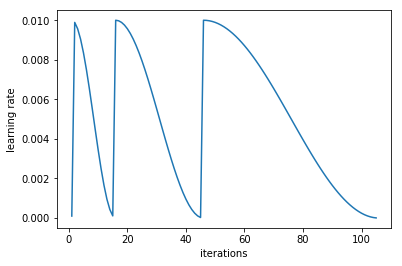

In [52]:
learn.sched.plot_lr()

Note that's what being plotted above is the learning rate of the *final layers*. The learning rates of the earlier layers are fixed at the same multiples of the final layer rates as we initially requested (i.e. the first layers have 100x smaller, and middle layers 10x smaller learning rates, since we set `lr=np.array([1e-4,1e-3,1e-2])`.

In [53]:
learn.save('Pastas_all')

In [54]:
learn.load('Pastas_all')

There is something else we can do with data augmentation: use it at *inference* time (also known as *test* time). Not surprisingly, this is known as *test time augmentation*, or just *TTA*.

TTA simply makes predictions not just on the images in your validation set, but also makes predictions on a number of randomly augmented versions of them too (by default, it uses the original image along with 4 randomly augmented versions). It then takes the average prediction from these images, and uses that. To use TTA on the validation set, we can use the learner's `TTA()` method.

In [55]:
log_preds,y = learn.TTA()
probs = np.mean(np.exp(log_preds),0)

In [56]:
accuracy_np(probs, y)

1.0

I generally see about a 10-20% reduction in error on this dataset when using TTA at this point, which is an amazing result for such a quick and easy technique!

## Analyzing results

### Confusion matrix 

In [57]:
preds = np.argmax(probs, axis=1)
probs = probs[:,1]

A common way to analyze the result of a classification model is to use a [confusion matrix](http://www.dataschool.io/simple-guide-to-confusion-matrix-terminology/). Scikit-learn has a convenient function we can use for this purpose:

In [58]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y, preds)

We can just print out the confusion matrix, or we can show a graphical view (which is mainly useful for dependents with a larger number of categories).

[[30  0]
 [ 0 30]]


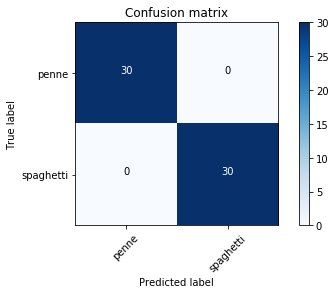

In [59]:
plot_confusion_matrix(cm, data.classes)

### Wow! We got 100% accuracy here under an hour of work with very few samples in a Deep Learning Neural Network. Its amazing!

### Looking at pictures again

In [60]:
plot_val_with_title(most_by_correct(0, False), "Most incorrect Spaghetti Pastas")

Most incorrect Spaghetti Pastas


<Figure size 1152x576 with 0 Axes>

In [61]:
plot_val_with_title(most_by_correct(1, False), "Most incorrect Penne Pastas")

Most incorrect Penne Pastas


<Figure size 1152x576 with 0 Axes>